## Full dataset (from 2017) for training and testing

- Train, test, cross validation split on all pre-normalised data

## Load files and plot

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import math
% matplotlib inline

In [38]:
# load normalised datasets
norm_filenames = [f for f in os.listdir() if f.endswith('normalized.csv')]
results_filenames = [f for f in os.listdir() if f.endswith('results.csv')]
raw_filenames = [f for f in os.listdir() if f.endswith('rawdata.csv')]

def load_files_concat(files):
    file_list = []
    for f in files:
        file_list.append(pd.read_csv(f, index_col = None))
    total_df = pd.concat(file_list)
    return total_df


results_df =load_files_concat(results_filenames).drop(['names','Order', 'L'], axis = 1)
raw_df = load_files_concat(raw_filenames).drop(['filecount','Order'], axis = 1)

In [99]:
def load_files_transpose_concat(files):
    file_list = []
    for f in files:
        file_list.append(pd.read_csv(f, index_col = None).set_index(['date','ID']).stack().reset_index())
    total_df = pd.concat(file_list)
    return total_df


norm_df = load_files_transpose_concat(norm_filenames)
norm_df.columns = ['date', 'ID','Wavelength','Intensity']
norm_df = norm_df[norm_df['Wavelength']!= 'Read']
norm_df = norm_df[norm_df['Wavelength']!= 'Unnamed: 0']
norm_df = norm_df[norm_df['Intensity']< 1000]

In [100]:
raw_plotdata = raw_df.drop(['Read','ID'], axis =1).groupby(['date','Wavelength']).agg([np.mean,np.std])
norm_df['Wavelength']= norm_df['Wavelength'].apply(lambda x: math.floor(float(x)))
norm_plotdata = norm_df.drop('ID', axis =1).groupby(['date','Wavelength']).agg([np.mean,np.std])

In [101]:
raw_plotdata.columns = raw_plotdata.columns.droplevel(0)
norm_plotdata.columns =norm_plotdata.columns.droplevel(0)

In [102]:
raw_plotdata = raw_plotdata.reset_index()
norm_plotdata = norm_plotdata.reset_index()

In [103]:
colours = {'Mar17': 'red', 'Apr17':'blue', 'May17': 'green', 'Aug17':'yellow', 'Nov17':'black'}
# map colours onto dataframe
raw_plotdata['Colour']= raw_plotdata['date'].map(colours)
norm_plotdata['Colour']= norm_plotdata['date'].map(colours)

# grouped by colour
raw_grouped = raw_plotdata.groupby('date')
norm_grouped = norm_plotdata.groupby('date')

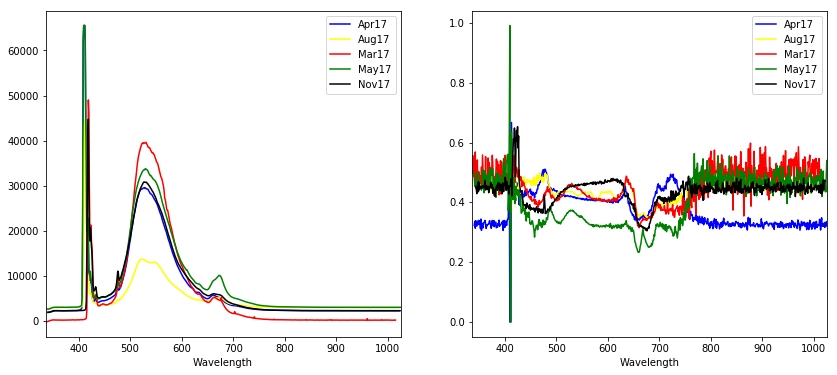

In [104]:
#plot
fig, ax = plt.subplots(1,2, figsize = (14, 6))
for key, value in raw_grouped:
     value.plot(ax = ax[0], x = 'Wavelength', y = 'mean', label = key, color = colours[key])
        
for key, value in norm_grouped:
     value.plot(ax = ax[1], x = 'Wavelength', y = 'mean', label = key, color = colours[key])    

## Train, test, cross validation split

In [134]:
def avg_over_col(df, num_col):
    new_df = pd.DataFrame()
    curr_col = 0
    for i in range(num_col,len(df.columns)+1, num_col):
        working_df = df.iloc[:,curr_col:i]
        colname = str(working_df.columns[0])
        new_df[colname]=working_df.mean(axis = 1)
        curr_col += num_col
    return(new_df)

In [154]:
## make wide df first and truncate data to between 450 and 850 nm
truncated_long =  norm_df[norm_df['Wavelength'].between(450, 850)].groupby(['date','ID','Wavelength']).agg(np.mean)
truncated_wide = truncated_long.unstack()
truncated_wide.columns = truncated_wide.columns.droplevel(0)
truncated_wide = avg_over_col(truncated_wide, 4)
truncated_wide = truncated_wide.reset_index()
full_df_norm = pd.merge(truncated_wide, results_df, on = ['ID','date'], how = 'left').dropna()


In [155]:
X_norm = full_df_norm.iloc[:, 2:-4]
Y = full_df_norm.iloc[:, -4:]
ID = full_df_norm.iloc[:,:1]

In [170]:
# K-fold validation with sklearn
from sklearn.model_selection import KFold
kf = KFold(n_splits = 3, random_state = 25, shuffle = True)
# sample code for training
for train_index, test_index in kf.split(X_norm):
    print('Train:', train_index, 'Test:', test_index)
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,:],Y.iloc[test_index,:]

Train: [  0   2   3   4   5   8  10  11  12  13  14  15  16  17  19  20  22  24
  25  27  28  29  31  32  33  34  36  40  41  42  44  45  46  47  48  50
  52  54  55  56  57  58  59  62  64  65  66  67  68  69  70  72  73  75
  76  78  79  82  83  85  86  87  88  89  90  93  95  98  99 101 102 104
 106 107 108 109 110 115 116 117 122 124 127 129 130 131 132 136 137 139
 141 143 145 146 147 148 149 151 154 155 156 158 159 160 164 165 167 168
 170 171 173 174 175 176 177 178 180 181 182 184 185 188 191 193 197 198
 199 200 201 202 203 204 206 208 210 212 213 214 216 217 220 222 223 225
 226 227 228 229 230 232 235 238 239 240 244 245 247 248 249 250 251 252
 253 255 257 258 259 260 261 263 265 267 269 272 274 275 277 281 282 283
 284 285 286 287 289 290 291 293 294 295 297 300 303 304 306 308 309 310
 312 313 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331
 332 333 334 337 338 339 340 341 342 348 349 350 351 352 353 354 355 356
 359 361 362 364 368 369 371 372 374 375 376

## Artificial neural nets for regression

In [166]:
from keras.models import Sequential
from keras.layers import Dense
import keras.regularizers as kr
from scipy.stats import linregress
from sklearn.metrics import r2_score

Using TensorFlow backend.


In [173]:
Y.head()

,C,F,M,P
0,22.0,2.96,16.7,3.71
1,84.0,4.73,24.4,3.97
2,28.0,4.15,18.6,3.73
3,265.0,3.47,44.5,2.99
4,13.0,4.49,31.0,3.47


mean squared error: 0.09696497996648153 Mean Absolute Error: 0.24791518211364746 R-squared: 0.23554915798200993
mean squared error: 0.09725679308176041 Mean Absolute Error: 0.24396170437335968 R-squared: 0.2043624655941696
mean squared error: 0.08415403082966805 Mean Absolute Error: 0.22266258557637533 R-squared: 0.2792600290695222


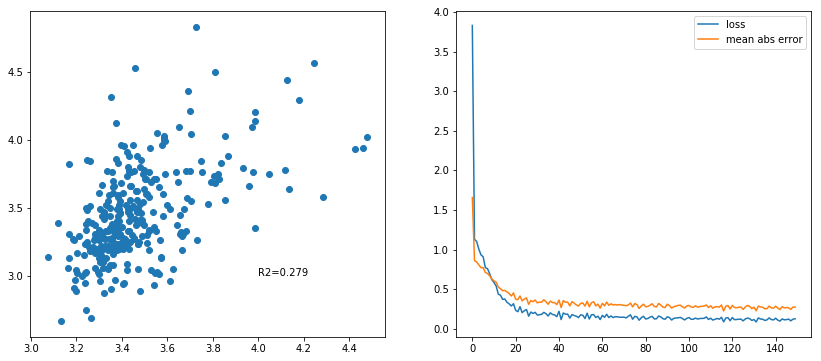

In [177]:
# regular ANN with 'relu' activation function, 'rmsprop' optimiser

for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]# for 'P' dependent var
    
    # model initiation
    model = Sequential()
    model.add(Dense(100, input_dim=100, activation='relu'))
    model.add(Dense(20, activation = 'relu'))
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= model.fit(X_train, y_train, epochs=150, batch_size=50, verbose =0)
    # predict
    y_predict = model.predict(X_test)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )
    
    
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
ax[0].text(4,3,'R2={0}'.format(round(r2,3)))

ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()

mean squared error: 0.2949600332975388 Mean Absolute Error: 0.23827604273955028 R-squared: 0.26715037829014565
mean squared error: 0.30408129970232645 Mean Absolute Error: 0.24833878219127656 R-squared: 0.09237020026485887
mean squared error: 0.29587854504585265 Mean Absolute Error: 0.22988066931565604 R-squared: 0.21351976845937515


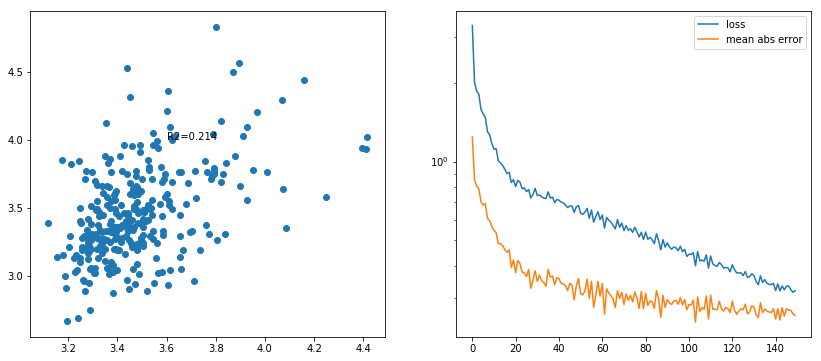

In [193]:
# With Lasso L1 regularization
w_reg = kr.l1(0.001)


for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]# for 'P' dependent var
    
    # model initiation
    model = Sequential()
    model.add(Dense(100, input_dim=100, activation='relu', kernel_regularizer = w_reg))
    model.add(Dense(10, activation = 'relu', kernel_regularizer = w_reg))
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= model.fit(X_train, y_train, epochs=150, batch_size=50, verbose =0)
    # predict
    y_predict = model.predict(X_test)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )
    
    
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
ax[0].text(3.6,4,'R2={0}'.format(round(r2,3)))

ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()
ax[1].set_yscale('log')

mean squared error: 0.09773611148198445 Mean Absolute Error: 0.24835629761219025 R-squared: 0.22946972188193748
mean squared error: 0.089781208584706 Mean Absolute Error: 0.23286139647165935 R-squared: 0.2655187148124072
mean squared error: 0.08861463287224372 Mean Absolute Error: 0.2268086878458659 R-squared: 0.24105707051783587


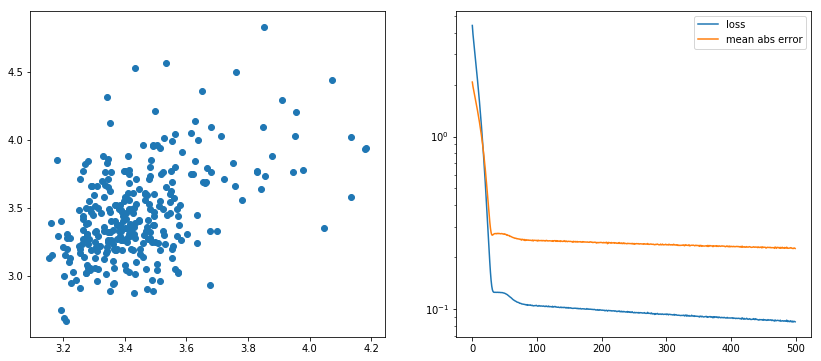

In [190]:
## sigmoid activation function
for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]# for 'P' dependent var
    
    model = Sequential()
    model.add(Dense(5, input_dim=100, activation='sigmoid'))
    model.add(Dense(3, activation = 'sigmoid')) # 3 hidden units
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= (model.fit(X_train, y_train, epochs=500, batch_size=50, verbose =0))
    # predict
    y_predict = model.predict(X_test)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )

fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
#ax[0].text(3,3,'R2={0}'.format(round(r2,3)))
ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()
ax[1].set_yscale('log')

mean squared error: 0.11819451197981834 Mean Absolute Error: 0.25619299232959747 R-squared: 0.14098937195147854
mean squared error: 0.10970425292849541 Mean Absolute Error: 0.23963825245698292 R-squared: 0.17518128662167098
mean squared error: 0.11102432325482368 Mean Absolute Error: 0.25011728912591935 R-squared: 0.13338522898743788


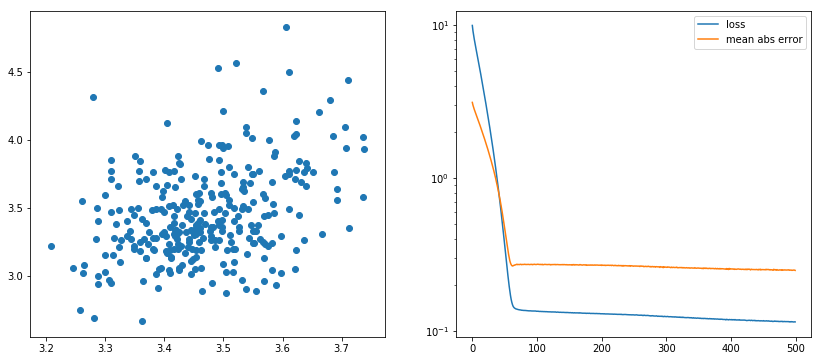

In [194]:
## sigmoid activation function with L1 regularization
w_reg = kr.l1(0.001)


for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]# for 'P' dependent var
    

    model = Sequential()
    model.add(Dense(5, input_dim=100, activation='sigmoid', kernel_regularizer = w_reg))
    model.add(Dense(3, activation = 'sigmoid', kernel_regularizer = w_reg)) # 3 hidden units
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= (model.fit(X_train, y_train, epochs=500, batch_size=50, verbose =0))
    # predict
    y_predict = model.predict(X_test)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )

    

fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
#ax[0].text(3,3,'R2={0}'.format(round(r2,3)))
ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()
ax[1].set_yscale('log')

## Linear regression + lasso regularisation

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


chosen alpha: 2.5002816116717638e-05 
R2: -0.24189685134838745


c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


chosen alpha: 2.4789411538634614e-05 
R2: -0.09647535166932308
chosen alpha: 2.6726318145307443e-05 
R2: -0.08217508436486387
r2: 0.39235428123737537


c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


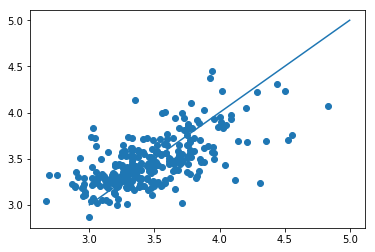

In [196]:
from sklearn.linear_model import LassoCV
for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]# for 'P' dependent var
    
    model= LassoCV(cv=20)
    model.fit(X_train, y_train)
    print("chosen alpha:", model.alpha_, '\nR2:', r2_score(y_test,y_predict))
    y_predict = model.predict(X_test)

fig , ax = plt.subplots()
ax.scatter(y_test,y_predict)
ax.plot([3,5],[3,5])
print('r2:', r2_score(y_test,y_predict))


### Support vector regression

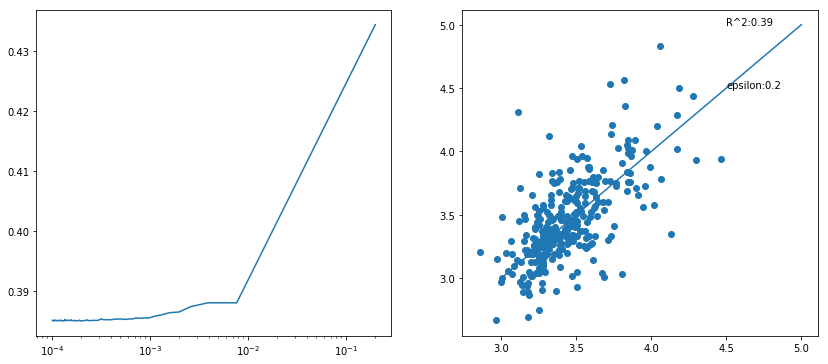

In [197]:
from sklearn.svm import SVR
# Vary epsilon, from initial tests, C appears to not have much effect on prediction accuracy
for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1] # for 'P' dependent 
    
    svr_prediction = []
    svr_r2 = []
    ep =[]

    for i in range(1,2000, 25):
        ep.append(0.2/i)
        clf = SVR(C= 30, epsilon = 0.2/i, kernel = 'linear')
        clf.fit(X_train, y_train)
        svr_prediction.append(clf.predict(X_test))
        svr_r2.append(clf.score(X_test,y_test))


    
fig , ax = plt.subplots(1,2, figsize = (14,6))
ax[1].scatter(svr_prediction[svr_r2.index(max(svr_r2))], y_test)
ax[1].text(4.5,5, "R^2:{0}".format(round(svr_r2[-1],2)))
ax[1].text(4.5,4.5, "epsilon:{0}".format(round(ep[svr_r2.index(max(svr_r2))],4)))
ax[0].plot(ep, svr_r2)
ax[0].set_xscale('log')
ax[1].plot([3,5],[3,5])

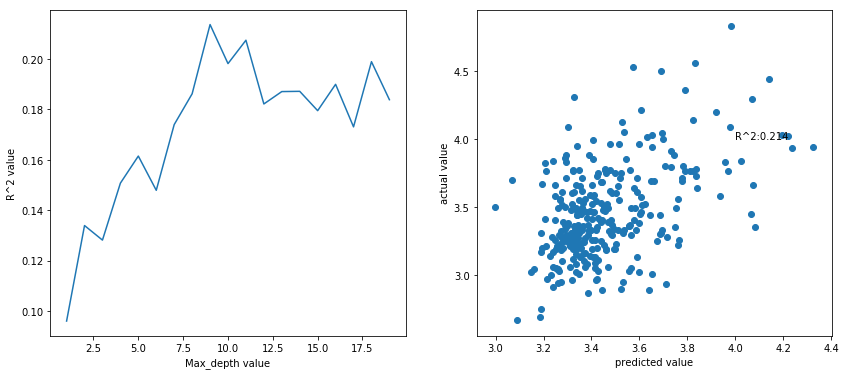

In [199]:
from sklearn.ensemble import RandomForestRegressor
    
    
for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1] # for 'P' dependent 
        
    
    rf_scores = []
    predictions=[]
    # need to try different max_depth:
    for depth in range(1, 20):
        rf = RandomForestRegressor(max_depth = depth, random_state=0)
        rf.fit(X_train, y_train)
        predictions.append(np.array(rf.predict(X_test)))
        rf_scores.append(rf.score(X_test, np.array(y_test)))
    
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].plot(range(1,20),rf_scores)
ax[0].set_ylabel('R^2 value')
ax[0].set_xlabel('Max_depth value')
ax[1].scatter(predictions[rf_scores.index(max(rf_scores))], y_test)
ax[1].text(4,4, "R^2:{0}".format(round(max(rf_scores),3)))
ax[1].set_xlabel('predicted value')
ax[1].set_ylabel('actual value')

## Exclude August dataset
- I think the August dataset is vastly different from the rest, try excluding
- Train, test, cross validation split on 4/5 pre-normalised datasets

## Train, test, cross validation split

In [134]:
def avg_over_col(df, num_col):
    new_df = pd.DataFrame()
    curr_col = 0
    for i in range(num_col,len(df.columns)+1, num_col):
        working_df = df.iloc[:,curr_col:i]
        colname = str(working_df.columns[0])
        new_df[colname]=working_df.mean(axis = 1)
        curr_col += num_col
    return(new_df)

In [200]:
## make wide df first and truncate data to between 450 and 850 nm
truncated_long =  norm_df[norm_df['Wavelength'].between(450, 850)].groupby(['date','ID','Wavelength']).agg(np.mean)
truncated_wide = truncated_long.unstack()
truncated_wide.columns = truncated_wide.columns.droplevel(0)
truncated_wide = avg_over_col(truncated_wide, 4)
truncated_wide = truncated_wide.reset_index()
full_df_norm = pd.merge(truncated_wide, results_df, on = ['ID','date'], how = 'left').dropna()
full_df_norm = full_df_norm[full_df_norm['date'] != 'Aug17']


In [201]:
X_norm = full_df_norm.iloc[:, 2:-4]
Y = full_df_norm.iloc[:, -4:]
ID = full_df_norm.iloc[:,:1]

In [202]:
# K-fold validation with sklearn
from sklearn.model_selection import KFold
kf = KFold(n_splits = 3, random_state = 25, shuffle = True)
# sample code for training
for train_index, test_index in kf.split(X_norm):
    print('Train:', train_index, 'Test:', test_index)
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,:],Y.iloc[test_index,:]

Train: [  0   2   3   5   8  10  11  12  13  14  15  16  17  18  20  22  24  25
  27  28  29  31  32  34  35  36  40  41  42  43  44  45  46  48  50  52
  54  55  56  57  58  59  62  64  65  66  67  68  69  70  72  73  74  75
  76  78  79  80  82  83  85  86  87  88  89  90  93  95  98  99 101 102
 104 106 107 108 109 110 116 117 122 124 126 127 129 130 131 132 136 137
 139 141 143 145 146 147 148 151 154 155 156 158 160 164 165 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 184 185 186 188 191
 193 195 197 198 199 200 201 202 203 204 206 208 209 212 213 214 216 217
 220 222 223 225 227 228 229 230 232 233 235 238 239 240 243 244 245 247
 248 249 250 251 252 253 254 255 256 257 258 259 260 261 263 265 267 268
 269 272 273 274 275 277 280 281 282 284 285 286 287 289 290 291 292 293
 294 295 297 300 301 303 304 305 306 307 308 309 310 312 313 314 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 332 333 334 335 339 340
 341 342 346 348 349 350 351 352 353 354 355

## Artificial neural nets for regression

In [203]:
from keras.models import Sequential
from keras.layers import Dense
import keras.regularizers as kr
from scipy.stats import linregress
from sklearn.metrics import r2_score

In [204]:
Y.head()

,C,F,M,P
0,22.0,2.96,16.7,3.71
1,84.0,4.73,24.4,3.97
2,28.0,4.15,18.6,3.73
3,265.0,3.47,44.5,2.99
4,13.0,4.49,31.0,3.47


mean squared error: 0.2570656263639057 Mean Absolute Error: 0.429642000841716 R-squared: -1.5075034492228752
mean squared error: 0.20028133950536214 Mean Absolute Error: 0.37352700697051155 R-squared: -0.6033414171682292
mean squared error: 0.32352908405046615 Mean Absolute Error: 0.49319019866368125 R-squared: -1.2277578859716152


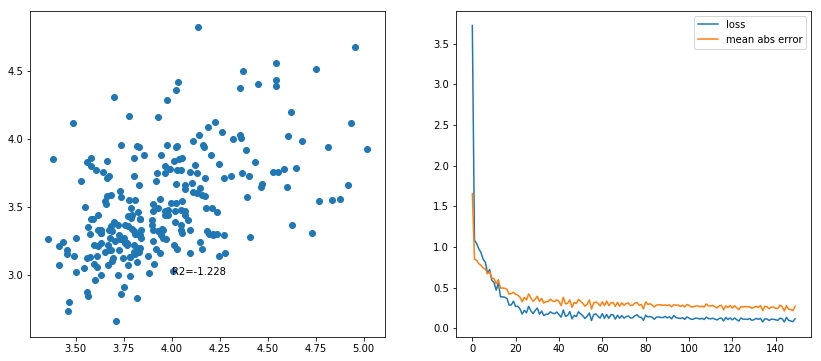

In [205]:
# regular ANN with 'relu' activation function, 'rmsprop' optimiser

for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]# for 'P' dependent var
    
    # model initiation
    model = Sequential()
    model.add(Dense(100, input_dim=100, activation='relu'))
    model.add(Dense(20, activation = 'relu'))
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= model.fit(X_train, y_train, epochs=150, batch_size=50, verbose =0)
    # predict
    y_predict = model.predict(X_test)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )
    
    
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
ax[0].text(4,3,'R2={0}'.format(round(r2,3)))

ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()

mean squared error: 0.3145433333184984 Mean Absolute Error: 0.23530966067124928 R-squared: 0.07908397523769028
mean squared error: 0.3338608651880234 Mean Absolute Error: 0.256631402742295 R-squared: 0.05235866264443978
mean squared error: 0.5432403456597101 Mean Absolute Error: 0.4857624622564467 R-squared: -1.2802876705615929


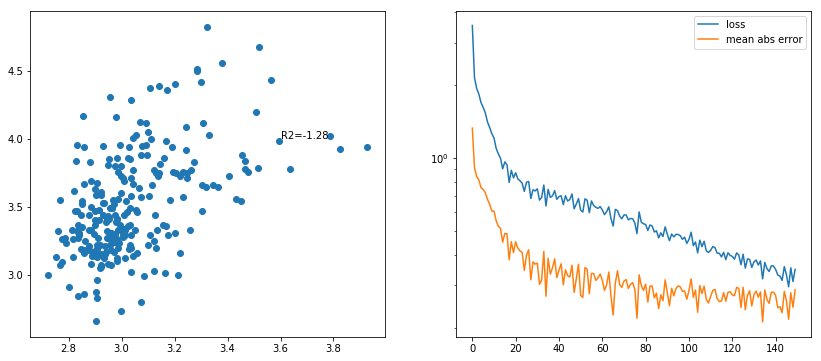

In [207]:
# With Lasso L1 regularization
w_reg = kr.l1(0.001)


for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]# for 'P' dependent var
    
    # model initiation
    model = Sequential()
    model.add(Dense(100, input_dim=100, activation='relu', kernel_regularizer = w_reg))
    model.add(Dense(10, activation = 'relu', kernel_regularizer = w_reg))
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= model.fit(X_train, y_train, epochs=150, batch_size=50, verbose =0)
    # predict
    y_predict = model.predict(X_test)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )
    
    
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
ax[0].text(3.6,4,'R2={0}'.format(round(r2,3)))

ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()
ax[1].set_yscale('log')

mean squared error: 0.06695958351095517 Mean Absolute Error: 0.20660550608521416 R-squared: 0.34685400203434313
mean squared error: 0.09345742252965768 Mean Absolute Error: 0.23820396855710044 R-squared: 0.25183172002689946
mean squared error: 0.10109373933029553 Mean Absolute Error: 0.24291445267578912 R-squared: 0.3038883223053508


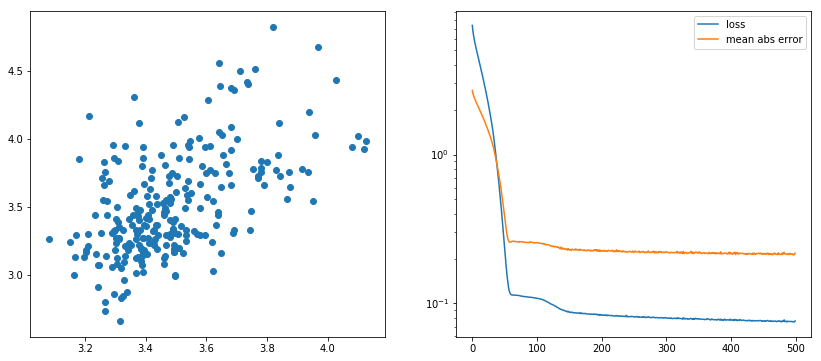

In [208]:
## sigmoid activation function
for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]# for 'P' dependent var
    
    model = Sequential()
    model.add(Dense(5, input_dim=100, activation='sigmoid'))
    model.add(Dense(3, activation = 'sigmoid')) # 3 hidden units
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= (model.fit(X_train, y_train, epochs=500, batch_size=50, verbose =0))
    # predict
    y_predict = model.predict(X_test)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )

fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
#ax[0].text(3,3,'R2={0}'.format(round(r2,3)))
ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()
ax[1].set_yscale('log')

mean squared error: 0.08931089618376323 Mean Absolute Error: 0.2194284870037957 R-squared: 0.2662222099897432
mean squared error: 0.11292316533979915 Mean Absolute Error: 0.24499694861116864 R-squared: 0.20448314351058017
mean squared error: 0.13765557754843954 Mean Absolute Error: 0.2790893671058473 R-squared: 0.11623900949832966


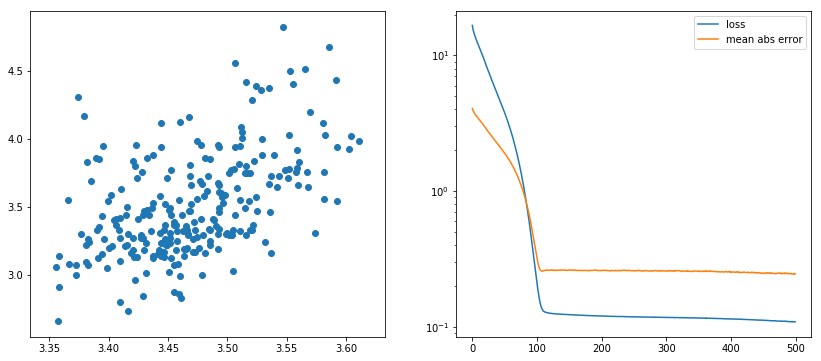

In [209]:
## sigmoid activation function with L1 regularization
w_reg = kr.l1(0.001)


for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]# for 'P' dependent var
    

    model = Sequential()
    model.add(Dense(5, input_dim=100, activation='sigmoid', kernel_regularizer = w_reg))
    model.add(Dense(3, activation = 'sigmoid', kernel_regularizer = w_reg)) # 3 hidden units
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= (model.fit(X_train, y_train, epochs=500, batch_size=50, verbose =0))
    # predict
    y_predict = model.predict(X_test)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )

    

fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
#ax[0].text(3,3,'R2={0}'.format(round(r2,3)))
ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()
ax[1].set_yscale('log')

## Linear regression + lasso regularisation

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


chosen alpha: 0.00013840945856866374 
R2: 0.4550577631871008


c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


chosen alpha: 5.246524933310937e-05 
R2: 0.3986027118118932
chosen alpha: 6.895155413612731e-05 
R2: 0.40112533875257206
r2: 0.40112533875257206


c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


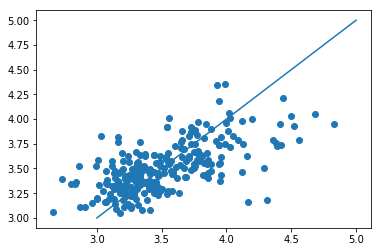

In [211]:
from sklearn.linear_model import LassoCV
for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]# for 'P' dependent var
    
    model= LassoCV(cv=20)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print("chosen alpha:", model.alpha_, '\nR2:', r2_score(y_test,y_predict))

fig , ax = plt.subplots()
ax.scatter(y_test,y_predict)
ax.plot([3,5],[3,5])
print('r2:', r2_score(y_test,y_predict))


### Support vector regression

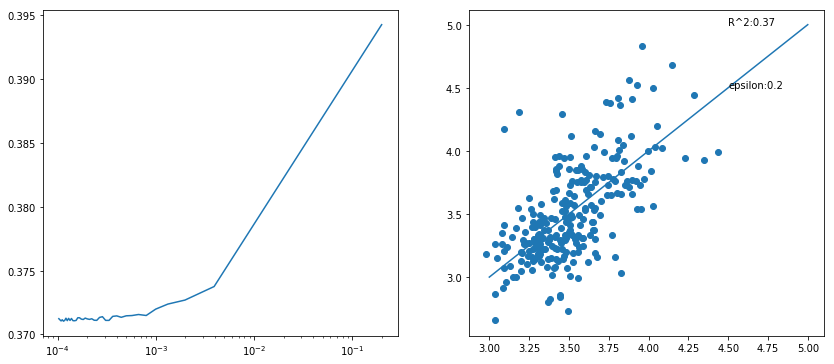

In [212]:
from sklearn.svm import SVR
# Vary epsilon, from initial tests, C appears to not have much effect on prediction accuracy
for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1] # for 'P' dependent 
    
    svr_prediction = []
    svr_r2 = []
    ep =[]

    for i in range(1,2000, 50):
        ep.append(0.2/i)
        clf = SVR(C= 30, epsilon = 0.2/i, kernel = 'linear')
        clf.fit(X_train, y_train)
        svr_prediction.append(clf.predict(X_test))
        svr_r2.append(clf.score(X_test,y_test))


    
fig , ax = plt.subplots(1,2, figsize = (14,6))
ax[1].scatter(svr_prediction[svr_r2.index(max(svr_r2))], y_test)
ax[1].text(4.5,5, "R^2:{0}".format(round(svr_r2[-1],2)))
ax[1].text(4.5,4.5, "epsilon:{0}".format(round(ep[svr_r2.index(max(svr_r2))],4)))
ax[0].plot(ep, svr_r2)
ax[0].set_xscale('log')
ax[1].plot([3,5],[3,5])

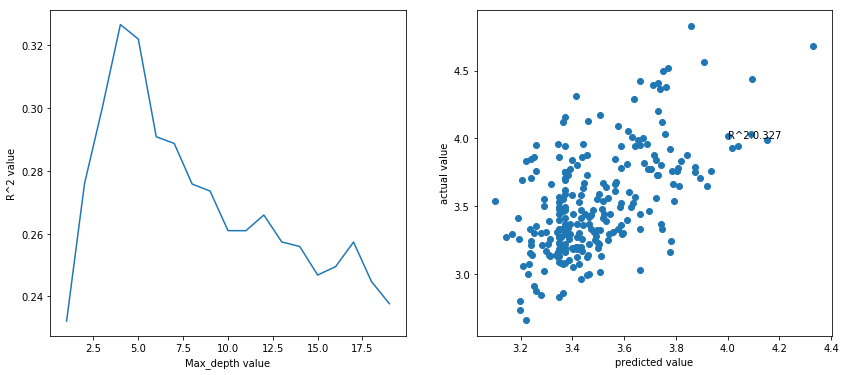

In [213]:
from sklearn.ensemble import RandomForestRegressor
    
    
for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1] # for 'P' dependent 
        
    
    rf_scores = []
    predictions=[]
    # need to try different max_depth:
    for depth in range(1, 20):
        rf = RandomForestRegressor(max_depth = depth, random_state=0)
        rf.fit(X_train, y_train)
        predictions.append(np.array(rf.predict(X_test)))
        rf_scores.append(rf.score(X_test, np.array(y_test)))
    
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].plot(range(1,20),rf_scores)
ax[0].set_ylabel('R^2 value')
ax[0].set_xlabel('Max_depth value')
ax[1].scatter(predictions[rf_scores.index(max(rf_scores))], y_test)
ax[1].text(4,4, "R^2:{0}".format(round(max(rf_scores),3)))
ax[1].set_xlabel('predicted value')
ax[1].set_ylabel('actual value')

### Use developed model on August dataset

## Full dataset (non-normalised) 

- perform normalisation on full dataset after concatanation

In [214]:
raw_df # still requires averaging across replicates, truncating, normalising

,ID,Intensity,Read,Wavelength,date
0,4364,2285.229722,1.0,340,Apr17
1,4364,2311.322361,1.0,341,Apr17
2,4364,2307.276991,1.0,342,Apr17
3,4364,2330.942407,1.0,343,Apr17
4,4364,2372.002917,1.0,344,Apr17
5,4364,2397.286481,1.0,345,Apr17
6,4364,2456.955694,1.0,346,Apr17
7,4364,2517.838518,1.0,347,Apr17
8,4364,2561.528519,1.0,348,Apr17
9,4364,2613.814931,1.0,349,Apr17


## Exclude August dataset (non-normalised)

### Use developed model on August dataset